In [2]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [3]:
import logging
import torch
import matplotlib.pyplot as plt
from games.ResourceGame import ResourceGame

import games.games as games
import policies.policies as policies

logging.getLogger('utils.module_loader').setLevel(logging.WARNING)
#logging.getLogger('utils.module_loader').setLevel(logging.INFO)

from utils.module_loader import initialize_game_system

# Load the game system
# games, policies = initialize_game_system()


<class 'games.games.ActionOneBetterThanActionZero'> 
    Action 1 is U(0, 999) when resources > 0, -1 when resources <= 0. Therefore should always gamble when resources > 0.
    
TransformerRLPolicy(
  (state_net): Sequential(
    (0): Linear(in_features=2, out_features=32, bias=True)
    (1): ReLU()
    (2): Linear(in_features=32, out_features=64, bias=True)
  )
  (action_embedding): Embedding(3, 64)
  (project): Linear(in_features=128, out_features=64, bias=True)
  (transformer): TransformerEncoder(
    (layers): ModuleList(
      (0-1): 2 x TransformerEncoderLayer(
        (self_attn): MultiheadAttention(
          (out_proj): NonDynamicallyQuantizableLinear(in_features=64, out_features=64, bias=True)
        )
        (linear1): Linear(in_features=64, out_features=128, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
        (linear2): Linear(in_features=128, out_features=64, bias=True)
        (norm1): LayerNorm((64,), eps=1e-05, elementwise_affine=True)
        (norm2)

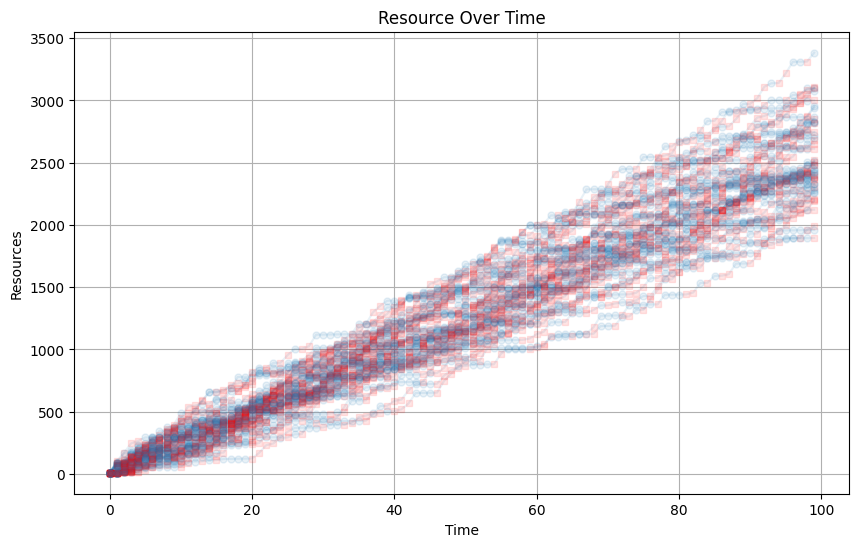

Average Reward at time by time 99, 50 sampled trajectories: 2548.08


In [4]:
import random
import numpy as np
import torch

# Set a fixed seed for reproducibility
SEED = 0
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)

game_class = games.ActionOneBetterThanActionZero
game = game_class()
print(game_class, game_class.__doc__)

policy_class = policies.TransformerRLPolicy
policy = policy_class()
print(policy, policy.__doc__)

import utils.utils as utils
utils.plot_rewards(utils.sample_trajectories(policy, game_class, n=50, max_step=100))

In [5]:
# #VERSION 1

# import torch
# import torch.nn as nn
# import torch.optim as optim
# import numpy as np
# import matplotlib.pyplot as plt
# from torch.distributions import Categorical
# import threading
# from queue import Queue

# ###############################################################################
# # Minimal ThreadEnv and VecEnv (unchanged)
# ###############################################################################
# def make_env(env_cls, max_steps=100):
#     """Creates an instance of the given environment class."""
#     return env_cls(max_steps=max_steps)

# class ThreadEnv:
#     """
#     Thread-based Environment Runner:
#     Uses threading instead of multiprocessing to avoid pickling issues.
#     """
#     def __init__(self, env_cls, max_steps=100):
#         self.env = make_env(env_cls, max_steps)
#         self.command_queue = Queue()
#         self.result_queue = Queue()
#         self.thread = threading.Thread(target=self._run, daemon=True)
#         self.thread.start()

#     def _run(self):
#         while True:
#             cmd, data = self.command_queue.get()
#             if cmd == 'step':
#                 result = self.env.step(data)
#                 self.result_queue.put(result)
#             elif cmd == 'reset':
#                 obs = self.env.reset()
#                 self.result_queue.put(obs)
#             elif cmd == 'close':
#                 break

#     def step(self, action):
#         self.command_queue.put(('step', action))
#         return self.result_queue.get()

#     def reset(self):
#         self.command_queue.put(('reset', None))
#         return self.result_queue.get()

#     def close(self):
#         self.command_queue.put(('close', None))
#         self.thread.join()

# class VecEnv:
#     """
#     Vectorized Environment Manager using threads instead of processes.
#     """
#     def __init__(self, env_cls, n_envs=1, max_steps=100):
#         self.envs = [ThreadEnv(env_cls, max_steps) for _ in range(n_envs)]
#         self.n_envs = n_envs

#     def step(self, actions):
#         return [env.step(action) for env, action in zip(self.envs, actions)]

#     def reset(self):
#         return [env.reset() for env in self.envs]

#     def close(self):
#         for env in self.envs:
#             env.close()

# ###############################################################################
# # RL Helpers
# ###############################################################################
# def discount_rewards(rewards, gamma=0.99):
#     """
#     Compute discounted rewards for a single episode.
#     """
#     discounted = []
#     running_sum = 0
#     for r in reversed(rewards):
#         running_sum = r + gamma * running_sum
#         discounted.insert(0, running_sum)
#     return discounted

# def reinforce_policy(env_cls, policy, 
#                     total_episodes=1000, 
#                     gamma=0.99, 
#                     lr=1e-6,
#                     max_steps=100,
#                     entropy_coef=0.01,
#                     max_grad_norm=0.5,
#                     batch_size=1):
#     """
#     REINFORCE implementation with improved state management and gradient handling
#     """
#     vec_env = VecEnv(env_cls, n_envs=batch_size, max_steps=max_steps)
#     optimizer = optim.Adam(policy.parameters(), lr=lr)
    
#     episodes_done = 0
#     loss_history = []
#     reward_history = []
#     entropy_history = []
    
#     try:
#         while episodes_done < total_episodes:
#             # Explicitly reset all storage
#             states = vec_env.reset()  # Reset environments
#             done_envs = [False] * batch_size
#             trajectories = [
#                 {
#                     'states': [],
#                     'actions': [],
#                     'rewards': [],
#                     'log_probs': [],
#                     'entropies': [],
#                 }
#                 for _ in range(batch_size)
#             ]
            
#             # Track active environments
#             active_env_mask = torch.ones(batch_size, dtype=torch.bool)
            
#             while not all(done_envs):
#                 # Get active states using the mask
#                 active_states = [s for s, d in zip(states, done_envs) if not d]
#                 if not active_states:  # Safety check
#                     break
                    
#                 state_tensor = torch.FloatTensor(active_states)
                
#                 # Forward pass with validation
#                 with torch.no_grad():  # Compute actions without tracking gradients
#                     action_probs = policy(state_tensor)
#                     dist = Categorical(action_probs)
#                     actions = dist.sample()
#                     log_probs = dist.log_prob(actions)
#                     entropies = dist.entropy()
                
#                 # Build actions list with explicit tracking
#                 env_actions = []
#                 active_idx = 0
#                 for env_idx in range(batch_size):
#                     if not done_envs[env_idx]:
#                         env_actions.append(actions[active_idx].item())
#                         active_idx += 1
#                     else:
#                         env_actions.append(None)
                
#                 # Step environments with validation
#                 active_results = []
#                 for env_idx, action in enumerate(env_actions):
#                     if not done_envs[env_idx]:
#                         try:
#                             result = vec_env.step([action])[0]
#                             active_results.append(result)
#                         except Exception as e:
#                             print(f"Error stepping env {env_idx}: {e}")
#                             break
                
#                 # Store transitions with careful indexing
#                 active_idx = 0
#                 for env_idx in range(batch_size):
#                     if not done_envs[env_idx]:
#                         result = active_results[active_idx]
                        
#                         # Explicitly detach tensors before storing
#                         trajectories[env_idx]['states'].append(states[env_idx])
#                         trajectories[env_idx]['actions'].append(env_actions[env_idx])
#                         trajectories[env_idx]['rewards'].append(result['reward'])
#                         trajectories[env_idx]['log_probs'].append(log_probs[active_idx].detach())
#                         trajectories[env_idx]['entropies'].append(entropies[active_idx].detach())
                        
#                         if result['done']:
#                             done_envs[env_idx] = True
#                             active_env_mask[env_idx] = False
#                         else:
#                             states[env_idx] = result['state']
                        
#                         active_idx += 1
            
#             episodes_done += batch_size
            
#             # Compute policy gradient loss with explicit gradient management
#             optimizer.zero_grad()  # Ensure gradients are cleared
            
#             # Collect and normalize returns across batch
#             all_discounted_returns = []
#             max_traj_length = max(len(traj['rewards']) for traj in trajectories)
            
#             for traj in trajectories:
#                 discounted = discount_rewards(traj['rewards'], gamma=gamma)
#                 all_discounted_returns.extend(discounted)
            
#             # Normalize returns
#             all_discounted_returns = torch.FloatTensor(all_discounted_returns)
#             if len(all_discounted_returns) > 0:  # Safety check
#                 normalized_returns = (all_discounted_returns - all_discounted_returns.mean()) / (all_discounted_returns.std() + 1e-8)
#             else:
#                 continue  # Skip update if no returns
                
#             # Compute losses with explicit detachment
#             start_idx = 0
#             batch_policy_loss = torch.zeros(1, requires_grad=True)
#             batch_entropy = torch.zeros(1, requires_grad=True)
            
#             for traj_idx, traj in enumerate(trajectories):
#                 traj_length = len(traj['rewards'])
#                 if traj_length == 0:  # Safety check
#                     continue
                    
#                 traj_returns = normalized_returns[start_idx:start_idx + traj_length]
#                 start_idx += traj_length
                
#                 # Recompute log probs with gradient tracking
#                 log_probs = torch.stack(traj['log_probs'])
#                 entropies = torch.stack(traj['entropies'])
                
#                 # Compute losses with validation
#                 trajectory_loss = -1 * (log_probs * traj_returns).sum()
#                 trajectory_entropy = entropies.mean()
                
#                 batch_policy_loss = batch_policy_loss + trajectory_loss
#                 batch_entropy = batch_entropy + trajectory_entropy
            
#             # Average losses
#             mean_policy_loss = batch_policy_loss / batch_size
#             mean_entropy = batch_entropy / batch_size
            
#             # Total loss
#             total_loss = mean_policy_loss - entropy_coef * mean_entropy
            
#             # Backward pass with gradient clipping
#             total_loss.backward()
#             torch.nn.utils.clip_grad_norm_(policy.parameters(), max_grad_norm)
#             optimizer.step()
            
#             # Store metrics (with detachment)
#             batch_reward = sum(sum(t['rewards']) for t in trajectories) / batch_size
#             reward_history.append(batch_reward)
#             loss_history.append(total_loss.detach().item())
#             entropy_history.append(mean_entropy.detach().item())

#             if episodes_done % (batch_size * 10) == 0:
#                 print(f"Episode {episodes_done}/{total_episodes}:")
#                 print(f"  Mean Loss: {total_loss.item():.6f}")
#                 print(f"  Mean Reward: {batch_reward:.2f}")
#                 print(f"  Mean Entropy: {mean_entropy.item():.6f}")
#                 print(f"  Grad Norms: {[p.grad.norm().item() for p in policy.parameters() if p.grad is not None]}")
#                 print("------------------------")

#     finally:
#         vec_env.close()

#     return policy, loss_history, reward_history, entropy_history

# # Usage example:
# if __name__ == '__main__':
#     # Define your game class and policy here
#     trained_policy = reinforce_policy(game_class, policy,
#                                     total_episodes=10000,
#                                     gamma=0.9,
#                                     lr=1e-6,
#                                     max_steps=100,
#                                     entropy_coef=0.01,
#                                     max_grad_norm=0.5, batch_size=10)

In [6]:
def discount_rewards(trajectory, gamma=0.9):
    rewards = [t[2] for t in trajectory]
    discounted_rewards = torch.zeros_like(torch.tensor(rewards, dtype=torch.float32))
    R = 0
    for t in reversed(range(len(rewards))):
        R = rewards[t] + gamma * R
        discounted_rewards[t] = R
    return discounted_rewards

def get_loss_for_batch(trajectories, action_logs):
    losses = []
    all_rewards = []
    
    # First collect all discounted rewards
    for trajectory, action_log in zip(trajectories, action_logs):
        discounted_rewards = discount_rewards(trajectory)
        all_rewards.append(discounted_rewards)
    
    # Concatenate and normalize across all trajectories
    all_rewards = torch.cat(all_rewards)
    normalized_rewards = (all_rewards - all_rewards.mean()) / (all_rewards.std() + 1e-8)
    
    # Split back into trajectory-sized chunks
    start_idx = 0
    for trajectory, action_log in zip(trajectories, action_logs):
        length = min(len(action_log), len(trajectory))
        trajectory_rewards = normalized_rewards[start_idx:start_idx + length]
        episode_loss = -1 * (action_log[:length] * trajectory_rewards).sum()
        losses.append(episode_loss)
        start_idx += length

    return torch.stack(losses).mean()

def sample_trajectories(policy, game, n=10, max_step=100):
    trajectories = []
    action_logs = []

    for _ in range(n):
        trajectory = []
        env = game()  # Assuming game() is defined elsewhere
        state = env.reset()
        episode_action_logs = []
        actions = []

        done = False
        while not done:
            # Original behavior for non-transformer policies
            states = env.states
    
            if len(actions) == 0:
                actions = [-1]
            action_probs = policy.get_next_action_dist(states, actions)

            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()
            
            log_prob = action_distribution.log_prob(action)
            actions.append(action.item())

            result = env.step(action.item())
            next_state, reward, done = result['state'], result['reward'], result['done']

            trajectory.append((state, action.item(), reward))
            episode_action_logs.append(log_prob)
            state = next_state

        trajectories.append(trajectory)
        action_logs.append(torch.stack(episode_action_logs))
    return trajectories, action_logs
    
    
def reinforce(policy, game, optimizer, n=10, max_step=100):
    trajectories = []
    action_logs = []

    trajectories, action_logs = sample_trajectories(policy, game, n=n, max_step=max_step)

    loss = get_loss_for_batch(trajectories, action_logs)

    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss over time')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [7]:
import torch.optim as optim

optimizer = optim.Adam(policy.parameters(), lr=0.001)

losses = []
for epoch in range(100):  # Run for 100 episodes
    loss = reinforce(policy, game_class, optimizer, n=10, max_step=100)
    losses.append(loss)
    print(f"Epoch {epoch}, Loss: {loss}")

policy.plot_policy_heatmap()

# Plot the losses

plot_loss(losses)
utils.plot_rewards(utils.sample_trajectories(policy, game_class, n=50, max_step=100))

/Users/pennyb/miniconda3/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Epoch 0, Loss: 2.5464694499969482
Epoch 1, Loss: -8.185800552368164
Epoch 2, Loss: -2.213059186935425
Epoch 3, Loss: -0.36934179067611694
Epoch 4, Loss: -0.022375525906682014
Epoch 5, Loss: -0.8273327946662903
Epoch 6, Loss: 4.921602157992311e-05
Epoch 7, Loss: -1.8779503079713322e-05
Epoch 8, Loss: 4.762648131872993e-06
Epoch 9, Loss: 7.560277481388766e-06
Epoch 10, Loss: 1.913522964969161e-06
Epoch 11, Loss: -1.0147703051188728e-06
Epoch 12, Loss: -3.2356126666854834e-07
Epoch 13, Loss: -1.2688978756614233e-07
Epoch 14, Loss: -8.354873415328257e-08
Epoch 15, Loss: 8.483221236588179e-09
Epoch 16, Loss: 2.0463630789890885e-12
Epoch 17, Loss: -7.332800816203799e-13
Epoch 18, Loss: 3.910827391095939e-12
Epoch 19, Loss: -5.826450433232822e-13
Epoch 20, Loss: -1.1652900866465643e-12
Epoch 21, Loss: 2.0463630789890885e-12
Epoch 22, Loss: -1.4892976175212569e-12
Epoch 23, Loss: -1.7848833305453282e-12
Epoch 24, Loss: -2.2396307898520096e-12
Epoch 25, Loss: -3.990407830556375e-12
Epoch 26, Lo

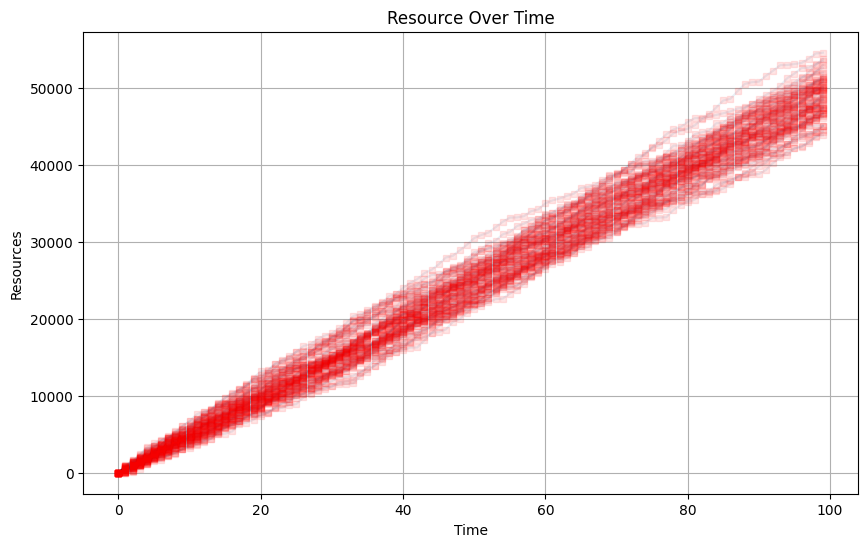

Average Reward at time by time 99, 50 sampled trajectories: 48900.62


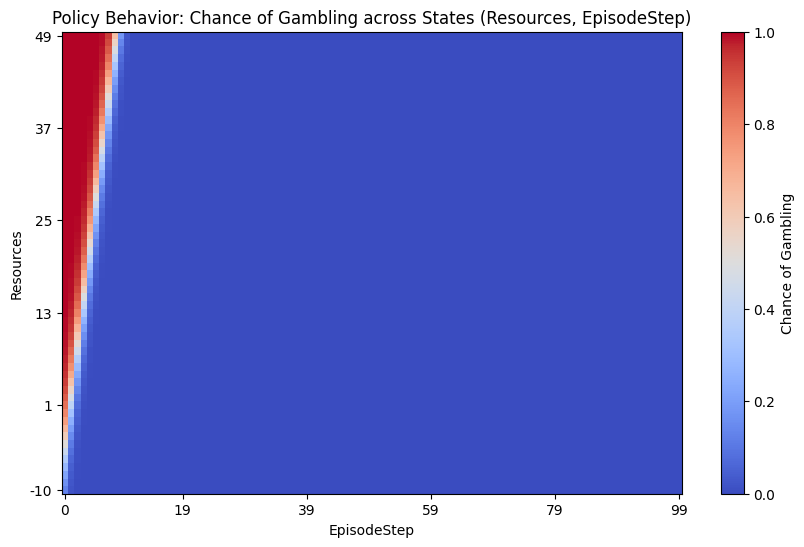

In [25]:
import utils.utils as utils
trajectories = utils.sample_trajectories(policy, game_class, n=50, max_step=100)
utils.plot_rewards(trajectories)
policy.plot_policy_heatmap()

Episode 10/1000:
  Mean Loss: 0.000044
  Mean Reward: 100.00
  Mean Entropy: 0.000010
------------------------
Episode 20/1000:
  Mean Loss: 0.000043
  Mean Reward: 100.00
  Mean Entropy: 0.000010
------------------------
Episode 30/1000:
  Mean Loss: 0.000042
  Mean Reward: 100.00
  Mean Entropy: 0.000010
------------------------
Episode 40/1000:
  Mean Loss: 0.000041
  Mean Reward: 100.00
  Mean Entropy: 0.000010
------------------------
Episode 50/1000:
  Mean Loss: 0.000040
  Mean Reward: 100.00
  Mean Entropy: 0.000009
------------------------
Episode 60/1000:
  Mean Loss: 0.000039
  Mean Reward: 100.00
  Mean Entropy: 0.000009
------------------------
Episode 70/1000:
  Mean Loss: 0.000038
  Mean Reward: 100.00
  Mean Entropy: 0.000009
------------------------
Episode 80/1000:
  Mean Loss: 0.000037
  Mean Reward: 100.00
  Mean Entropy: 0.000009
------------------------
Episode 90/1000:
  Mean Loss: 0.000036
  Mean Reward: 100.00
  Mean Entropy: 0.000009
------------------------
E

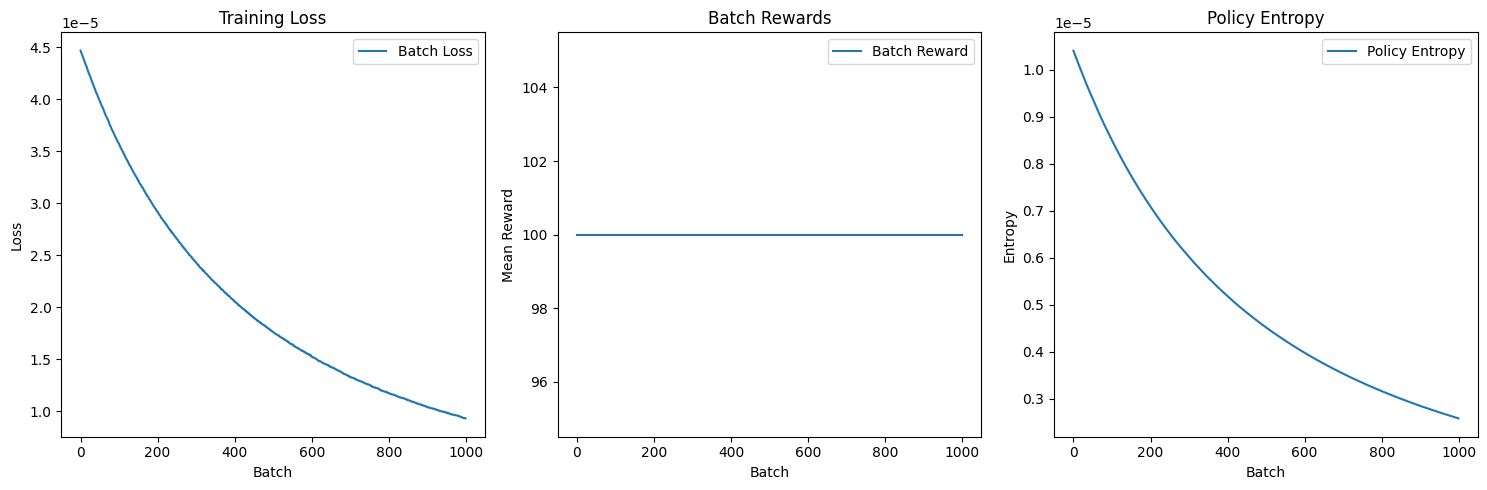

In [49]:
# Usage example:
if __name__ == '__main__':
    # Your game and policy definitions here
    trained_policy = reinforce_policy(game_class, policy,
                                           total_episodes=1000,
                                           gamma=0.9,
                                           lr=1e-4,
                                           max_steps=100)

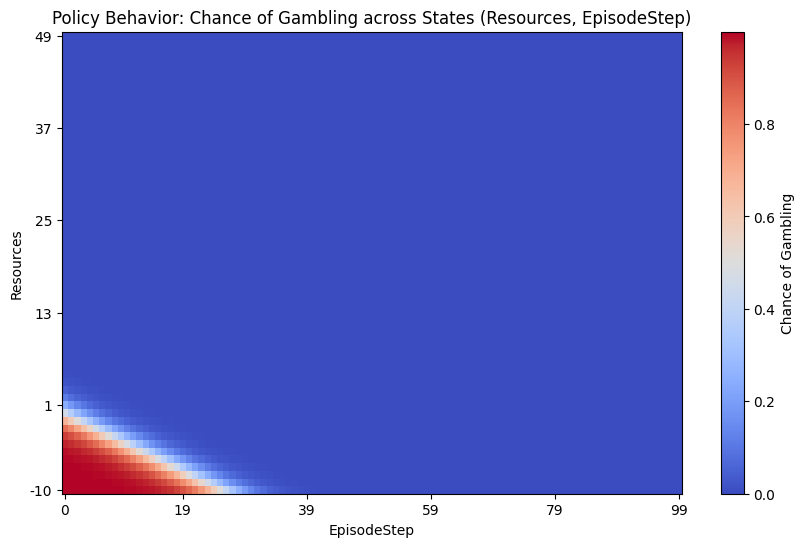

In [57]:
policy.plot_policy_heatmap()

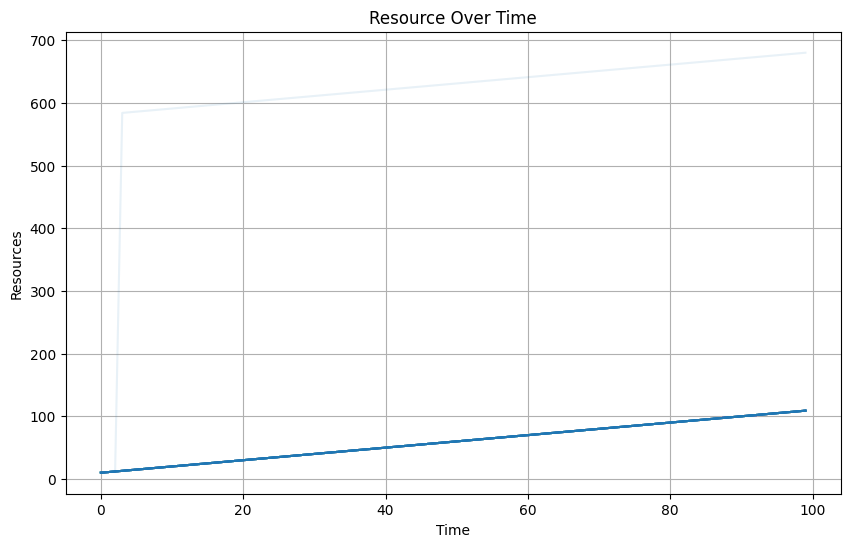

Final state - Time: 99, Resources: [109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 680, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109, 109]


In [59]:
import utils.utils as utils
trajectories = utils.sample_trajectories(policy, game_class, n=50, max_step=100)
utils.plot_rewards(trajectories)

/Users/pennyb/Desktop/toy-transformer/RL/utils/utils.py:28: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:264.)
  states = torch.FloatTensor(state_history).unsqueeze(0)


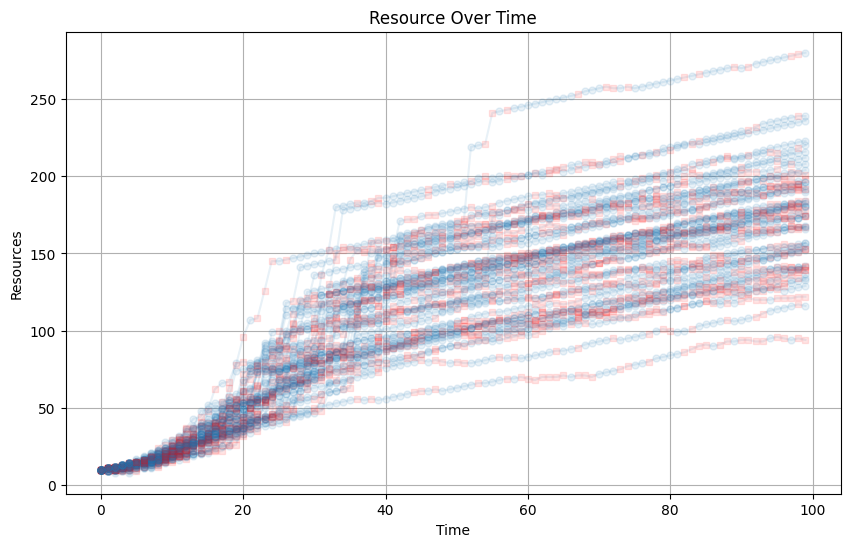

Final state - Time: 99, Resources: [152, 198, 167, 133, 142, 223, 157, 168, 166, 190, 129, 239, 236, 196, 181, 201, 184, 191, 208, 94, 204, 180, 139, 137, 134, 174, 174, 142, 178, 175, 153, 141, 116, 174, 183, 181, 167, 194, 192, 220, 155, 139, 212, 184, 153, 196, 157, 280, 122, 216]
(112.0556, 60.05260784212456)


In [4]:
trajectories = utils.sample_trajectories(policy, game_class, n=50, max_step=100)
utils.plot_rewards(trajectories)
print(utils.get_trajectories_mean(trajectories))

In [27]:
class EmbeddingModel(nn.Module):
    def __init__(self, vocab_size, embedding_dim):
        super(EmbeddingModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embedding_dim)
    
    def forward(self, x):
        if not isinstance(x, torch.LongTensor):
            x = x.long()
        return self.embedding(x)

In [100]:
import torch
import torch.nn as nn

class TransformerPolicy(allPastStatePolicy):
    def __init__(self, max_resource=1000, max_steps=100, input_action_vocab_size=3, output_action_vocab_size=2, d_model=6, nhead=3, num_layers=4, max_seq_length=100):
        super().__init__()
        self.max_seq_length = max_seq_length
        self.max_resource = max_resource
        self.max_steps = max_steps
        self.action_vocab_size = input_action_vocab_size
        
        # Embeddings
        self.resource_embedding = nn.Embedding(max_resource + 1, d_model // 3)
        self.step_embedding = nn.Embedding(max_steps + 1, d_model // 3)
        self.action_embedding = nn.Embedding(input_action_vocab_size, d_model // 3)
        
        # Positional encoding
        self.positional_encoding = nn.Parameter(torch.zeros(1, max_seq_length, d_model))
        
        # Transformer layers
        encoder_layer = nn.TransformerEncoderLayer(d_model=d_model, nhead=nhead)
        self.transformer_encoder = nn.TransformerEncoder(encoder_layer, num_layers=num_layers)
        
        # Output layer
        self.fc_out = nn.Linear(d_model, output_action_vocab_size)

    def forward(self, states, action_history):
        # Process states
        resources, steps = zip(*states)
        resources = torch.tensor([min(r, self.max_resource) for r in resources]).unsqueeze(0)
        steps = torch.tensor([min(s, self.max_steps) for s in steps]).unsqueeze(0)
        
        # Process action history
        actions = torch.tensor(action_history).unsqueeze(0)
        
        # Determine the sequence length
        seq_len = max(resources.size(1), actions.size(1))
        
        # Pad sequences to match the longest sequence
        if resources.size(1) < seq_len:
            pad_length = seq_len - resources.size(1)
            resources = torch.nn.functional.pad(resources, (0, pad_length), value=self.max_resource)
            steps = torch.nn.functional.pad(steps, (0, pad_length), value=self.max_steps)
        if actions.size(1) < seq_len:
            pad_length = seq_len - actions.size(1)
            actions = torch.nn.functional.pad(actions, (0, pad_length), value=self.action_vocab_size-1)
        
        # Embed resources, steps, and actions
        resource_embed = self.resource_embedding(resources)
        step_embed = self.step_embedding(steps)
        action_embed = self.action_embedding(actions)
        
        # Combine embeddings
        x = torch.cat([resource_embed, step_embed, action_embed], dim=-1)
        
        # Add positional encoding
        x = x + self.positional_encoding[:, :x.size(1), :]
        
        # Transformer expects shape: (seq_len, batch_size, d_model)
        x = x.permute(1, 0, 2)
        
        # Pass through Transformer
        x = self.transformer_encoder(x)
        
        # We're interested in the output for the last item in the sequence
        x = x[-1]
        
        # Output layer
        x = self.fc_out(x)
        
        return torch.softmax(x, dim=-1)

    def get_action(self, states, action_history):
        with torch.no_grad():
            action_probs = self.forward(states, action_history)
        return torch.multinomial(action_probs, 1).item()

In [101]:
policy = TransformerPolicy()

# Example state and action history
states = [[10,  0]]  # [[resource, step], ...]
action_history = [2]

# Get action probabilities
action_probs = policy(states, action_history)
print("Action probabilities:", action_probs)

# Get a specific action
action = policy.get_action(states, action_history)
print("Sampled action:", action)

Action probabilities: tensor([[0.7050, 0.2950]], grad_fn=<SoftmaxBackward0>)
Sampled action: 0


In [61]:
def get_loss_for_trajectory(trajectories, action_logs):
    def discount_rewards(trajectory, gamma=0.9):
        rewards = [t[2] for t in trajectory]
        discounted_rewards = torch.zeros_like(torch.tensor(rewards, dtype=torch.float32))
        R = 0
        for t in reversed(range(len(rewards))):
            R = rewards[t] + gamma * R
            discounted_rewards[t] = R
        return discounted_rewards

    losses = []
    for trajectory, action_log in zip(trajectories, action_logs):
        discounted_rewards = discount_rewards(trajectory)
        
        min_len = min(len(action_log), len(discounted_rewards))
        action_log = action_log[:min_len]
        discounted_rewards = discounted_rewards[:min_len]
        
        discounted_rewards = (discounted_rewards - discounted_rewards.mean()) / (discounted_rewards.std() + 1e-8)
        
        episode_loss = -1 * (action_log * discounted_rewards).sum()
        losses.append(episode_loss)

    return torch.stack(losses).mean()

def reinforce(policy, game, optimizer, n=10):
    trajectories = []
    action_logs = []

    for _ in range(n):
        trajectory = []
        env = game()  # Assuming game() is defined elsewhere
        state = env.reset()
        episode_action_logs = []

        done = False
        while not done:
            if issubclass(policy.__class__, allPastStatePolicy):
                states = env.states
                actions = env.actions
                if actions == []:
                    actions = [2]
                action_probs = policy(states, actions)
            else:
                # Original behavior for non-transformer policies
                state_tensor = torch.FloatTensor(state)
                action_probs = policy(state_tensor)

            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()
            log_prob = action_distribution.log_prob(action)

            result = env.step(action.item())
            next_state, reward, done = result['state'], result['reward'], result['done']

            trajectory.append((state, action.item(), reward))
            episode_action_logs.append(log_prob)
            state = next_state

        trajectories.append(trajectory)
        action_logs.append(torch.stack(episode_action_logs))

    loss = get_loss_for_trajectory(trajectories, action_logs)
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    return loss.item()

def plot_loss(losses):
    plt.figure(figsize=(10, 5))
    plt.plot(losses)
    plt.title('Loss over time')
    plt.xlabel('Episode')
    plt.ylabel('Loss')
    plt.grid(True)
    plt.show()

In [62]:
import torch.optim as optim

optimizer = optim.Adam(policy.parameters(), lr=0.01)

losses = []
for epoch in range(100):  # Run for 100 episodes
    loss = reinforce(policy, game_class, optimizer)
    losses.append(loss)
    print(f"Epoch {epoch}, Loss: {loss}")

policy.plot_policy_heatmap()

# Plot the losses

plot_loss(losses)

NameError: name 'allPastStatePolicy' is not defined

In [88]:
def sample_trajectories(policy, game, n=10, max_step=10):
    trajectories = []

    for _ in range(n):
        trajectory = []
        env = game() 
        state = env.reset()
        done = False
        step = 0

        while (not done) and (step < max_step):
            if issubclass(policy.__class__, allPastStatePolicy):
                actions = env.actions
                states = env.states

                if len(actions) == 0:
                    actions = [2]
                action_probs = policy(states, actions)
            else:
                # Original behavior for non-transformer policies
                state_tensor = torch.FloatTensor(state)
                action_probs = policy(state_tensor)

            action_distribution = torch.distributions.Categorical(action_probs)
            action = action_distribution.sample()

            result = env.step(action.item())
            next_state, reward, done = result['state'], result['reward'], result['done']

            trajectory.append((state, action.item(), reward))

            state = next_state
            step += 1
        trajectories.append(trajectory)
    return trajectories

trajectories = sample_trajectories(policy, game_class, n=50, max_step=100)

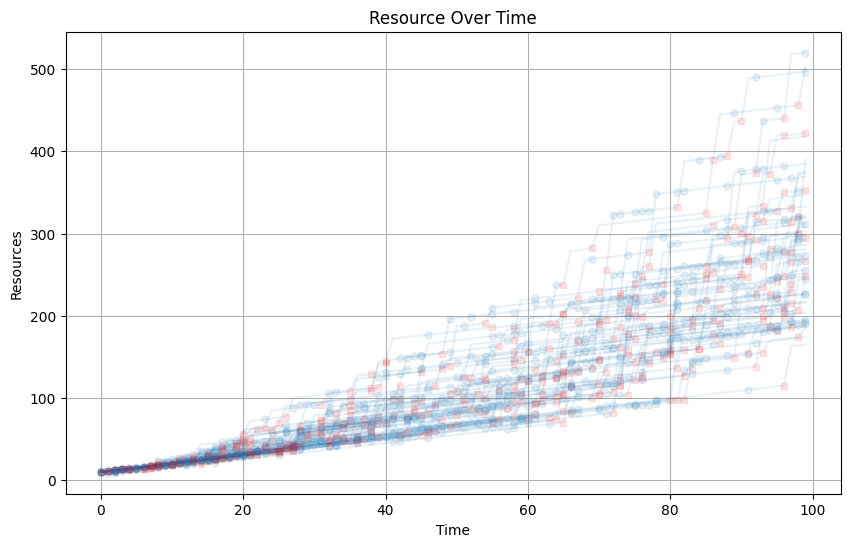

Final state - Time: 99, Resources: [303, 391, 194, 292, 256, 497, 312, 313, 297, 286, 187, 195, 226, 245, 294, 217, 333, 192, 227, 309, 269, 418, 204, 353, 375, 520, 248, 308, 347, 299, 385, 276, 188, 504, 246, 320, 216, 266, 422, 373, 322, 251, 174, 187, 190, 165, 319, 273, 281, 369]


(115.4924, 92.2632794899466)

In [94]:
utils.plot_rewards(trajectories)
utils.get_trajectories_mean(trajectories)

In [95]:
trajectories

[[(array([10,  0]), 2, 1),
  (array([11,  1]), 2, 1),
  (array([12,  2]), 2, 1),
  (array([13,  3]), 0, 1),
  (array([14,  4]), 2, 1),
  (array([15,  5]), 2, 1),
  (array([16,  6]), 2, 1),
  (array([17,  7]), 0, 1),
  (array([18,  8]), 2, 1),
  (array([19,  9]), 2, 1),
  (array([20, 10]), 1, 1),
  (array([21, 11]), 0, 1),
  (array([22, 12]), 2, 1),
  (array([23, 13]), 2, 1),
  (array([24, 14]), 2, 1),
  (array([25, 15]), 2, 1),
  (array([26, 16]), 2, 1),
  (array([27, 17]), 0, 1),
  (array([28, 18]), 2, 1),
  (array([29, 19]), 2, 1),
  (array([30, 20]), 2, 1),
  (array([31, 21]), 2, 1),
  (array([32, 22]), 2, 1),
  (array([33, 23]), 2, 1),
  (array([34, 24]), 2, 1),
  (array([35, 25]), 2, 1),
  (array([36, 26]), 2, 1),
  (array([37, 27]), 2, 1),
  (array([38, 28]), 2, 1),
  (array([39, 29]), 2, 1),
  (array([40, 30]), 2, 1),
  (array([41, 31]), 2, 1),
  (array([42, 32]), 0, 1),
  (array([43, 33]), 0, 1),
  (array([44, 34]), 2, 1),
  (array([45, 35]), 2, 1),
  (array([46, 36]), 2, 1),
 

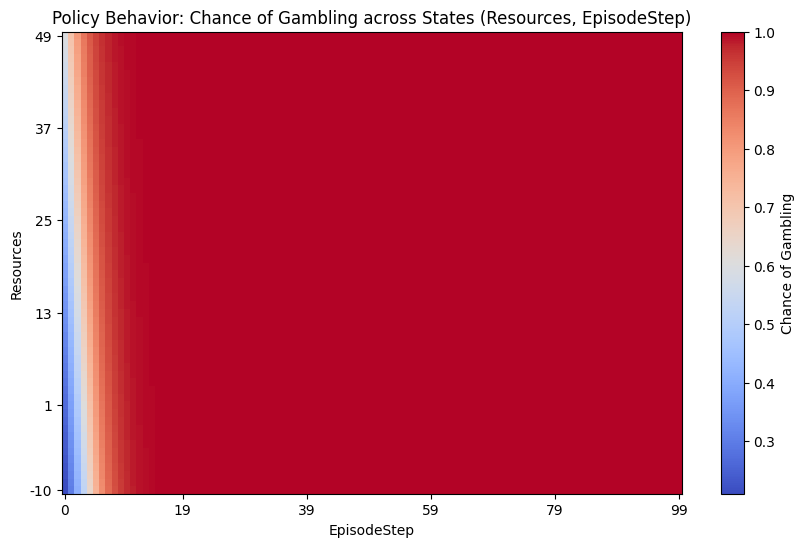

In [7]:
policy.plot_policy_heatmap()

[10  0]


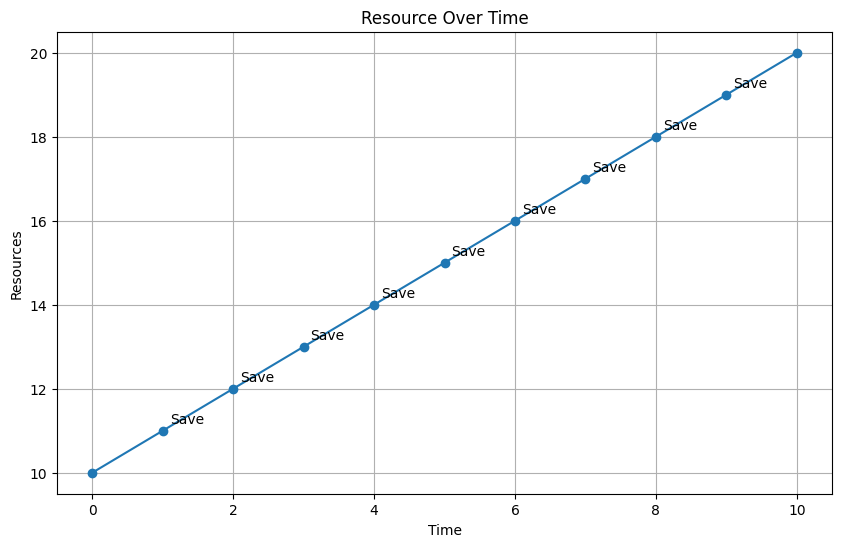

Final state - Time: 10, Resources: 20


In [ ]:
# Example usage
for t in range(1, 11):  # Run for 10 steps
    state = torch.FloatTensor(state)
    sampled_action = torch.multinomial(simplePolicy(state), num_samples=1).item()
    state, reward, done, _ = env.step(sampled_action)
    resources.append(state[0])
    times.append(t)
    actions.append('Spend' if sampled_action == 1 else 'Save')
    if done:
        break

plot_rewards(times, resources, actions)

In [ ]:
import torch.optim as optim

def train_policy(env, episodes=1000, lr=0.01):
    input_dim = 2  # resources and step_count
    output_dim = 2  # save or spend
    policy = SimplePolicy(input_dim, output_dim)
    optimizer = optim.Adam(policy.parameters(), lr=lr)

    for episode in range(episodes):
        state = env.reset()
        episode_reward = 0
        
        while True:
            state_tensor = torch.FloatTensor(state)
            action_probs = policy(state_tensor)
            action = torch.multinomial(action_probs, num_samples=1).item()
            
            next_state, reward, done, _ = env.step(action)
            
            episode_reward = next_state[0]
            print(f"state: {state}, reward: {reward}")
            
            # Compute loss and update policy
            loss = -1 * torch.log(action_probs[action]) * reward
            optimizer.zero_grad()

            loss.backward()

            optimizer.step()
            
            state = next_state
            
            if done:
                break
        
        if (episode + 1) % 100 == 0:
            print(f"Episode {episode + 1}, Reward: {episode_reward}")
            policy.plot_policy_heatmap()
        # elif episode + 1 < 10:
        #     policy.plot_policy_heatmap()
        #     print(f"Episode {episode + 1}, Reward: {episode_reward}")

    return policy

state: [10  0], reward: 0
state: [10  1], reward: 1
state: [11  2], reward: 1
state: [12  3], reward: 3
state: [15  4], reward: 2
state: [17  5], reward: 1
state: [18  6], reward: 0
state: [18  7], reward: 1
state: [19  8], reward: -1
state: [18  9], reward: 0
state: [18 10], reward: 2
state: [20 11], reward: 1
state: [21 12], reward: 0
state: [21 13], reward: 1
state: [22 14], reward: -1
state: [21 15], reward: 0
state: [21 16], reward: 3
state: [24 17], reward: 2
state: [26 18], reward: 0
state: [26 19], reward: 0
state: [26 20], reward: 1
state: [27 21], reward: 0
state: [27 22], reward: 1
state: [28 23], reward: 0
state: [28 24], reward: 3
state: [31 25], reward: 3
state: [34 26], reward: 1
state: [35 27], reward: -1
state: [34 28], reward: -1
state: [33 29], reward: 3
state: [36 30], reward: 3
state: [39 31], reward: 0
state: [39 32], reward: -1
state: [38 33], reward: 2
state: [40 34], reward: 1
state: [41 35], reward: 3
state: [44 36], reward: 0
state: [44 37], reward: 2
state: 

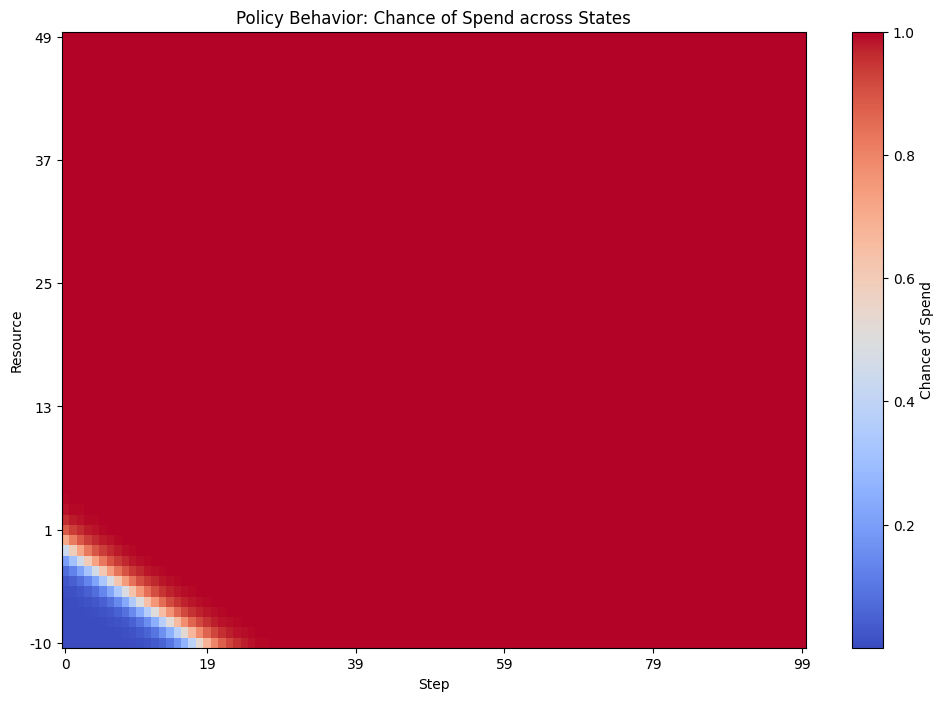

state: [10  0], reward: 0
state: [10  1], reward: -1
state: [9 2], reward: 0
state: [9 3], reward: -1
state: [8 4], reward: 3
state: [11  5], reward: -1
state: [10  6], reward: 3
state: [13  7], reward: 0
state: [13  8], reward: 1
state: [14  9], reward: 0
state: [14 10], reward: -1
state: [13 11], reward: -1
state: [12 12], reward: -1
state: [11 13], reward: -1
state: [10 14], reward: -1
state: [ 9 15], reward: 3
state: [12 16], reward: 1
state: [13 17], reward: 3
state: [16 18], reward: 2
state: [18 19], reward: 2
state: [20 20], reward: 0
state: [20 21], reward: 0
state: [20 22], reward: 2
state: [22 23], reward: 2
state: [24 24], reward: 0
state: [24 25], reward: 2
state: [26 26], reward: 0
state: [26 27], reward: 1
state: [27 28], reward: 2
state: [29 29], reward: 2
state: [31 30], reward: 3
state: [34 31], reward: 1
state: [35 32], reward: 2
state: [37 33], reward: 2
state: [39 34], reward: 1
state: [40 35], reward: 3
state: [43 36], reward: 1
state: [44 37], reward: 3
state: [47

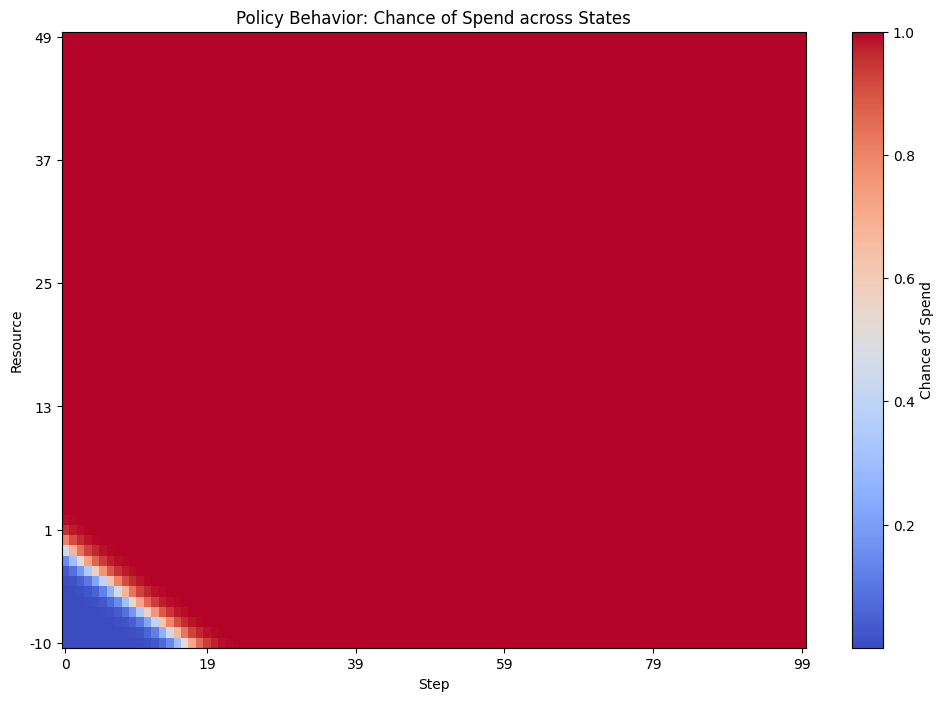

state: [10  0], reward: 3
state: [13  1], reward: 2
state: [15  2], reward: 1
state: [16  3], reward: 1
state: [17  4], reward: 1
state: [18  5], reward: 0
state: [18  6], reward: 0
state: [18  7], reward: 2
state: [20  8], reward: -1
state: [19  9], reward: 2
state: [21 10], reward: 1
state: [22 11], reward: 0
state: [22 12], reward: 0
state: [22 13], reward: 2
state: [24 14], reward: 2
state: [26 15], reward: 0
state: [26 16], reward: 1
state: [27 17], reward: 3
state: [30 18], reward: 2
state: [32 19], reward: -1
state: [31 20], reward: -1
state: [30 21], reward: -1
state: [29 22], reward: 1
state: [30 23], reward: 2
state: [32 24], reward: -1
state: [31 25], reward: 1
state: [32 26], reward: 0
state: [32 27], reward: 3
state: [35 28], reward: 2
state: [37 29], reward: -1
state: [36 30], reward: 2
state: [38 31], reward: 3
state: [41 32], reward: 0
state: [41 33], reward: 0
state: [41 34], reward: 2
state: [43 35], reward: 2
state: [45 36], reward: 1
state: [46 37], reward: -1
state

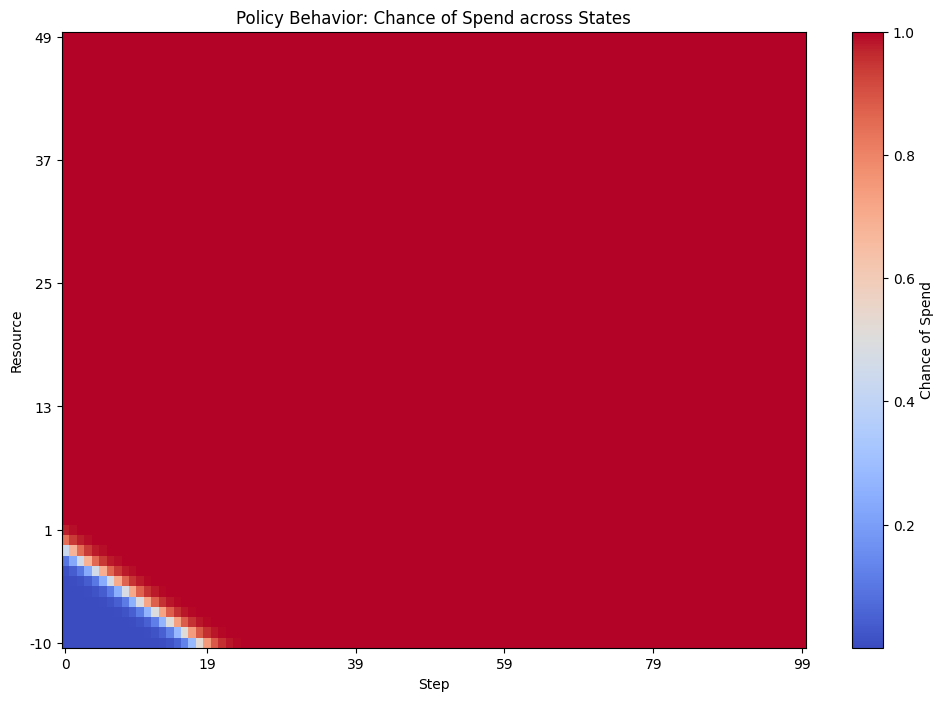

state: [10  0], reward: -1
state: [9 1], reward: 0
state: [9 2], reward: 2
state: [11  3], reward: 0
state: [11  4], reward: 3
state: [14  5], reward: 3
state: [17  6], reward: 0
state: [17  7], reward: 0
state: [17  8], reward: 3
state: [20  9], reward: 3
state: [23 10], reward: 3
state: [26 11], reward: -1
state: [25 12], reward: -1
state: [24 13], reward: 1
state: [25 14], reward: 3
state: [28 15], reward: 3
state: [31 16], reward: -1
state: [30 17], reward: -1
state: [29 18], reward: 1
state: [30 19], reward: 1
state: [31 20], reward: 1
state: [32 21], reward: -1
state: [31 22], reward: 0
state: [31 23], reward: 2
state: [33 24], reward: -1
state: [32 25], reward: 0
state: [32 26], reward: -1
state: [31 27], reward: 3
state: [34 28], reward: 3
state: [37 29], reward: -1
state: [36 30], reward: 0
state: [36 31], reward: 1
state: [37 32], reward: 0
state: [37 33], reward: 2
state: [39 34], reward: -1
state: [38 35], reward: -1
state: [37 36], reward: 2
state: [39 37], reward: 1
state

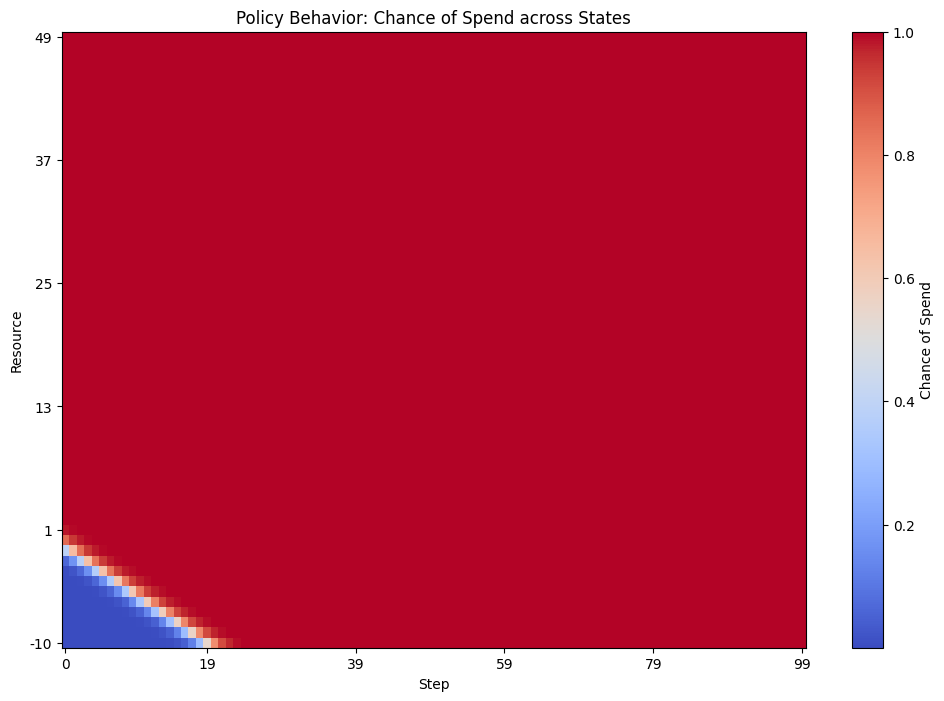

state: [10  0], reward: 1
state: [11  1], reward: 1
state: [12  2], reward: 0
state: [12  3], reward: 3
state: [15  4], reward: 0
state: [15  5], reward: 1
state: [16  6], reward: 0
state: [16  7], reward: 0
state: [16  8], reward: 0
state: [16  9], reward: 0
state: [16 10], reward: 3
state: [19 11], reward: 3
state: [22 12], reward: 2
state: [24 13], reward: -1
state: [23 14], reward: 0
state: [23 15], reward: 0
state: [23 16], reward: 1
state: [24 17], reward: 0
state: [24 18], reward: 3
state: [27 19], reward: 3
state: [30 20], reward: 1
state: [31 21], reward: 0
state: [31 22], reward: -1
state: [30 23], reward: 2
state: [32 24], reward: 3
state: [35 25], reward: -1
state: [34 26], reward: 1
state: [35 27], reward: 2
state: [37 28], reward: 2
state: [39 29], reward: -1
state: [38 30], reward: 2
state: [40 31], reward: 0
state: [40 32], reward: 0
state: [40 33], reward: 2
state: [42 34], reward: 0
state: [42 35], reward: 1
state: [43 36], reward: 1
state: [44 37], reward: 3
state: [

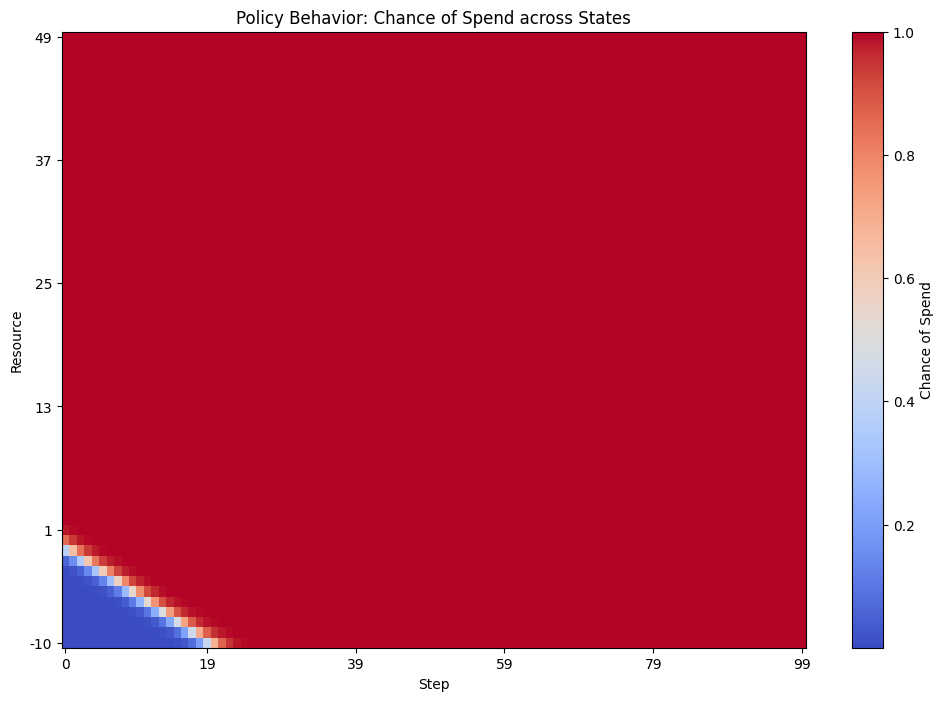

state: [10  0], reward: 3
state: [13  1], reward: -1
state: [12  2], reward: 3
state: [15  3], reward: 3
state: [18  4], reward: 1
state: [19  5], reward: 3
state: [22  6], reward: 0
state: [22  7], reward: -1
state: [21  8], reward: 1
state: [22  9], reward: -1
state: [21 10], reward: 1
state: [22 11], reward: 0
state: [22 12], reward: 1
state: [23 13], reward: 1
state: [24 14], reward: 1
state: [25 15], reward: 1
state: [26 16], reward: 1
state: [27 17], reward: 1
state: [28 18], reward: 1
state: [29 19], reward: 3
state: [32 20], reward: 1
state: [33 21], reward: 2
state: [35 22], reward: 0
state: [35 23], reward: 1
state: [36 24], reward: -1
state: [35 25], reward: 3
state: [38 26], reward: 1
state: [39 27], reward: -1
state: [38 28], reward: 0
state: [38 29], reward: 2
state: [40 30], reward: 3
state: [43 31], reward: -1
state: [42 32], reward: 1
state: [43 33], reward: 2
state: [45 34], reward: 3
state: [48 35], reward: 2
state: [50 36], reward: 3
state: [53 37], reward: 2
state:

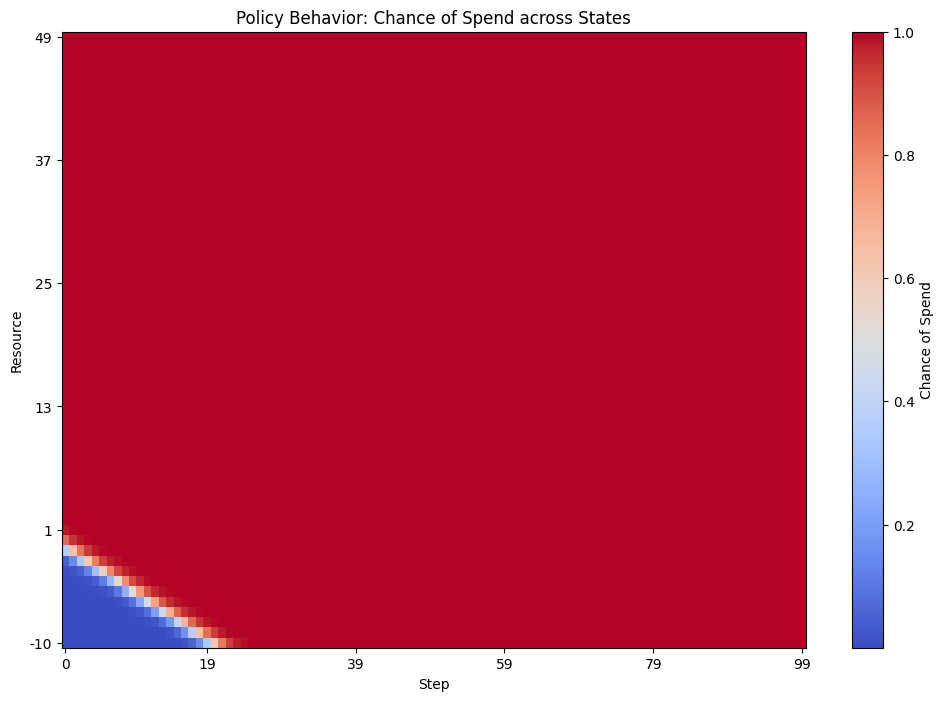

state: [10  0], reward: 0
state: [10  1], reward: 3
state: [13  2], reward: 0
state: [13  3], reward: 0
state: [13  4], reward: 3
state: [16  5], reward: -1
state: [15  6], reward: 2
state: [17  7], reward: 3
state: [20  8], reward: -1
state: [19  9], reward: 1
state: [20 10], reward: 2
state: [22 11], reward: 2
state: [24 12], reward: 3
state: [27 13], reward: -1
state: [26 14], reward: 3
state: [29 15], reward: 0
state: [29 16], reward: 2
state: [31 17], reward: -1
state: [30 18], reward: 1
state: [31 19], reward: -1
state: [30 20], reward: 2
state: [32 21], reward: -1
state: [31 22], reward: 0
state: [31 23], reward: 0
state: [31 24], reward: 2
state: [33 25], reward: 1
state: [34 26], reward: -1
state: [33 27], reward: 3
state: [36 28], reward: 2
state: [38 29], reward: 3
state: [41 30], reward: 1
state: [42 31], reward: 3
state: [45 32], reward: -1
state: [44 33], reward: 2
state: [46 34], reward: 0
state: [46 35], reward: 3
state: [49 36], reward: 1
state: [50 37], reward: 3
stat

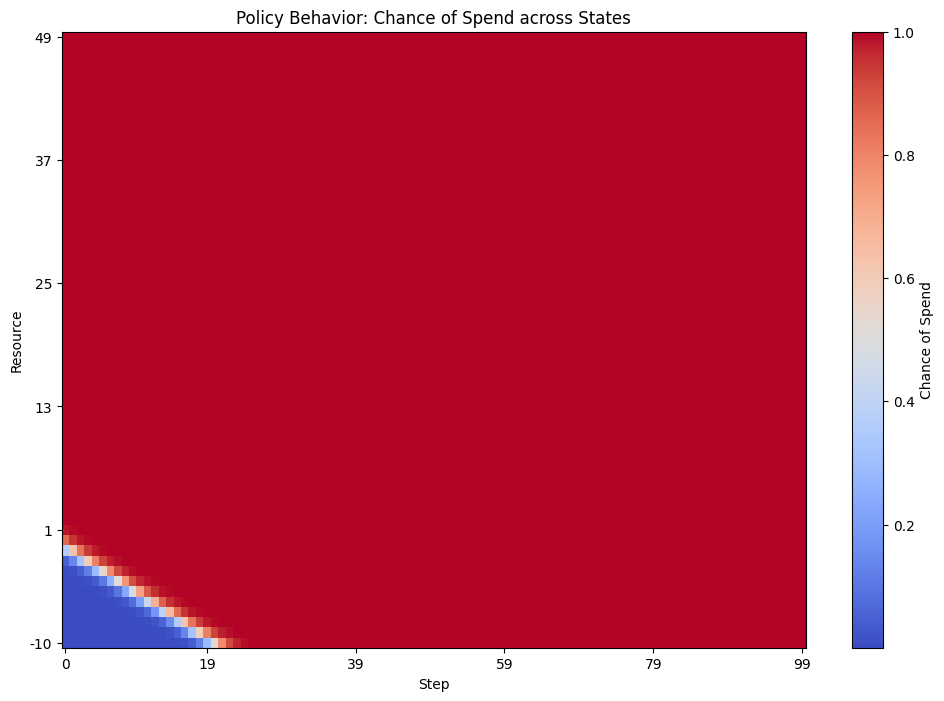

state: [10  0], reward: 0
state: [10  1], reward: 3
state: [13  2], reward: 0
state: [13  3], reward: 2
state: [15  4], reward: 0
state: [15  5], reward: 0
state: [15  6], reward: 2
state: [17  7], reward: -1
state: [16  8], reward: 1
state: [17  9], reward: 2
state: [19 10], reward: -1
state: [18 11], reward: 3
state: [21 12], reward: 0
state: [21 13], reward: 1
state: [22 14], reward: 2
state: [24 15], reward: 0
state: [24 16], reward: 1
state: [25 17], reward: 0
state: [25 18], reward: 1
state: [26 19], reward: 1
state: [27 20], reward: 3
state: [30 21], reward: -1
state: [29 22], reward: 0
state: [29 23], reward: 1
state: [30 24], reward: 3
state: [33 25], reward: 0
state: [33 26], reward: 1
state: [34 27], reward: 0
state: [34 28], reward: 3
state: [37 29], reward: 2
state: [39 30], reward: 3
state: [42 31], reward: 0
state: [42 32], reward: 3
state: [45 33], reward: -1
state: [44 34], reward: -1
state: [43 35], reward: -1
state: [42 36], reward: 0
state: [42 37], reward: 2
state:

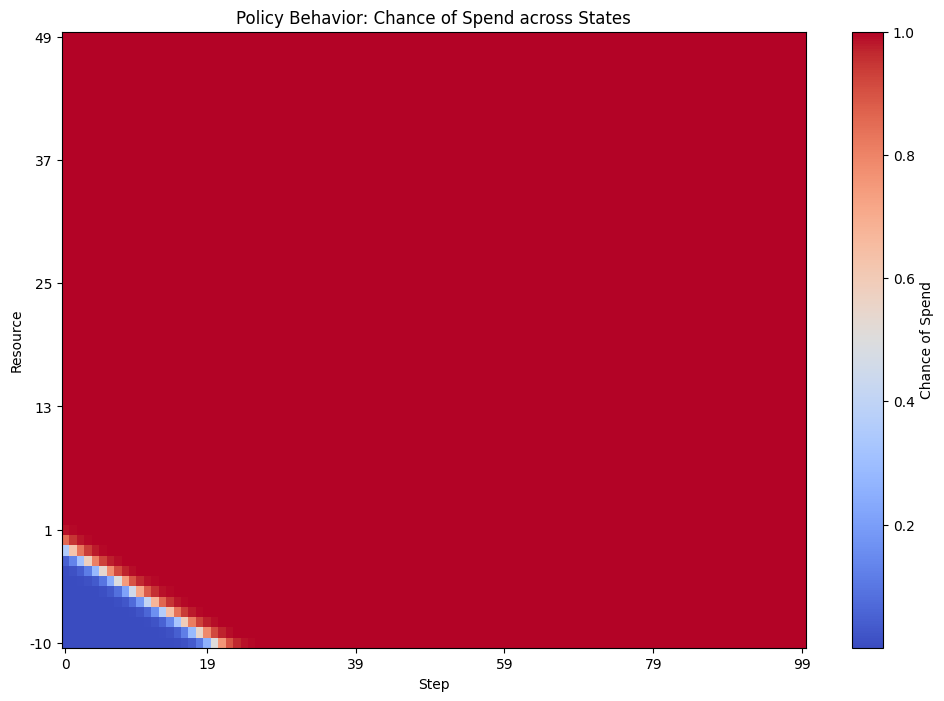

state: [10  0], reward: -1
state: [9 1], reward: 1
state: [10  2], reward: 3
state: [13  3], reward: 0
state: [13  4], reward: -1
state: [12  5], reward: 1
state: [13  6], reward: 3
state: [16  7], reward: 3
state: [19  8], reward: -1
state: [18  9], reward: 1
state: [19 10], reward: 0
state: [19 11], reward: 2
state: [21 12], reward: -1
state: [20 13], reward: -1
state: [19 14], reward: 3
state: [22 15], reward: 0
state: [22 16], reward: 0
state: [22 17], reward: -1
state: [21 18], reward: 2
state: [23 19], reward: 0
state: [23 20], reward: 2
state: [25 21], reward: 1
state: [26 22], reward: 3
state: [29 23], reward: -1
state: [28 24], reward: -1
state: [27 25], reward: -1
state: [26 26], reward: 2
state: [28 27], reward: 0
state: [28 28], reward: 2
state: [30 29], reward: 2
state: [32 30], reward: -1
state: [31 31], reward: -1
state: [30 32], reward: 2
state: [32 33], reward: 3
state: [35 34], reward: -1
state: [34 35], reward: 2
state: [36 36], reward: 0
state: [36 37], reward: 0
st

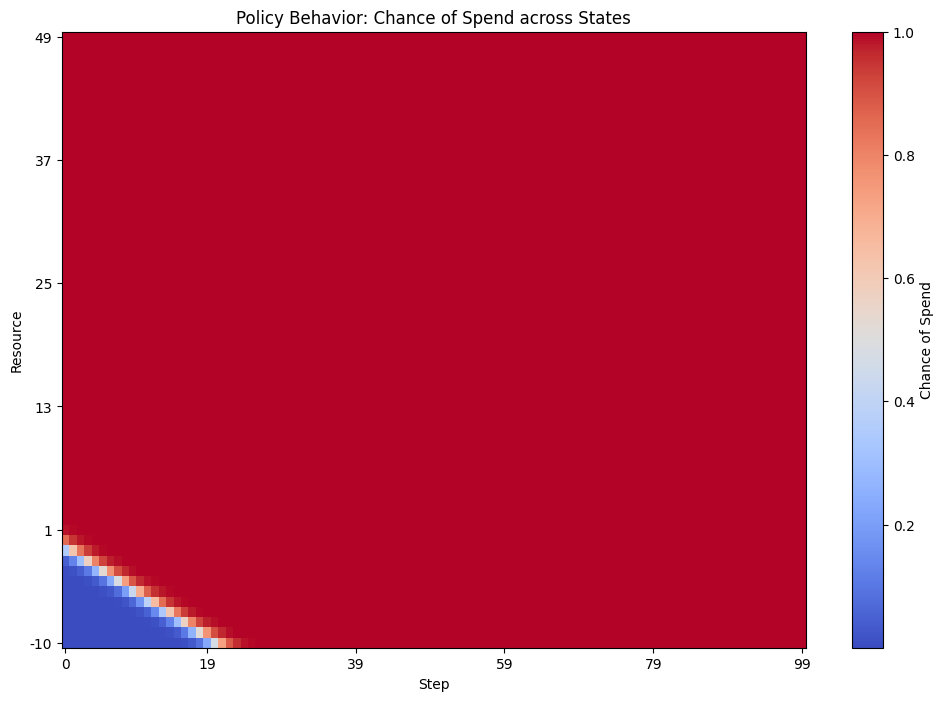

state: [10  0], reward: 1
state: [11  1], reward: 1
state: [12  2], reward: 1
state: [13  3], reward: 2
state: [15  4], reward: 0
state: [15  5], reward: 0
state: [15  6], reward: -1
state: [14  7], reward: 0
state: [14  8], reward: 0
state: [14  9], reward: 3
state: [17 10], reward: -1
state: [16 11], reward: 2
state: [18 12], reward: -1
state: [17 13], reward: -1
state: [16 14], reward: 3
state: [19 15], reward: -1
state: [18 16], reward: 2
state: [20 17], reward: 1
state: [21 18], reward: 3
state: [24 19], reward: 2
state: [26 20], reward: 3
state: [29 21], reward: 0
state: [29 22], reward: 2
state: [31 23], reward: 2
state: [33 24], reward: -1
state: [32 25], reward: 0
state: [32 26], reward: -1
state: [31 27], reward: 3
state: [34 28], reward: -1
state: [33 29], reward: 2
state: [35 30], reward: -1
state: [34 31], reward: 0
state: [34 32], reward: 2
state: [36 33], reward: 0
state: [36 34], reward: 1
state: [37 35], reward: 3
state: [40 36], reward: 1
state: [41 37], reward: 0
sta

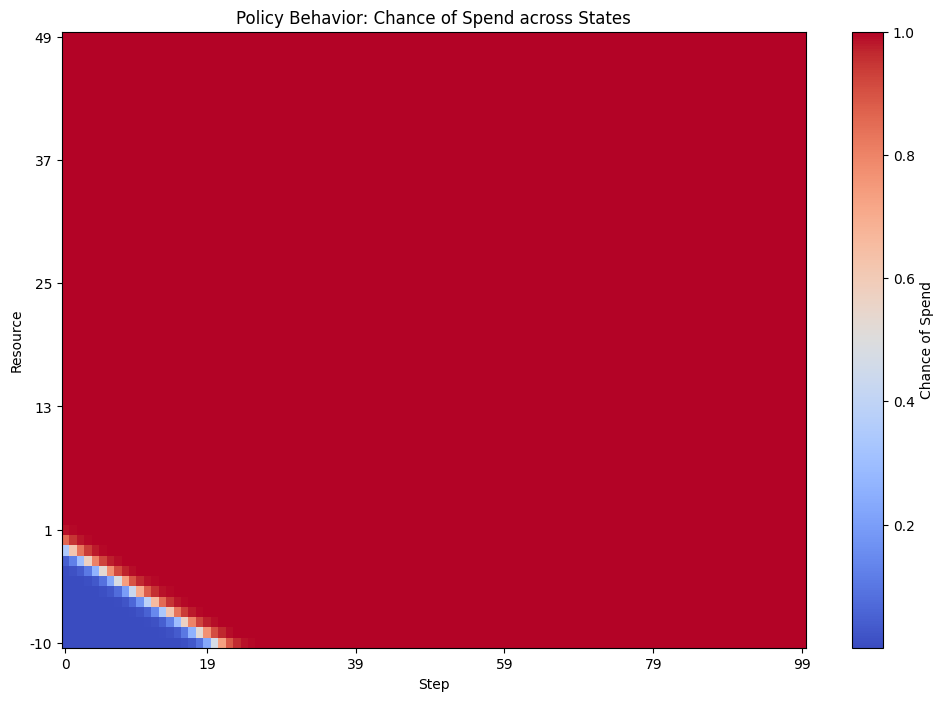

In [ ]:
# Train the agent
env = game()
trained_policy = train_policy(env)

In [ ]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# Assuming HarderResourceGame and trained_policy are defined elsewhere

test_episodes = 100
trained_rewards = []
always_spend_rewards = []
always_save_rewards = []
episode_numbers = []

for episode in range(test_episodes):
    env_trained = game()
    env_spend = game()
    env_save = game()

    state_trained = env_trained.reset()
    state_spend = env_spend.reset()
    state_save = env_save.reset()

    episode_trained_reward = 0
    episode_spend_reward = 0
    episode_save_reward = 0
    
    done = False
    while not done:
        # Trained policy
        state_tensor = torch.FloatTensor(state_trained)
        action_probs = trained_policy(state_tensor)
        action = torch.multinomial(action_probs, num_samples=1).item()
        state_trained, reward_trained, done, _ = env_trained.step(action)

        episode_trained_reward += reward_trained

        # Always spend policy
        state_spend, reward_spend, _, _ = env_spend.step(1)
        episode_spend_reward += reward_spend

        print(reward_spend)

        # Always save policy
        state_save, reward_save, _, _ = env_save.step(0)
       
    print()

    trained_rewards.append(episode_trained_reward)
    always_spend_rewards.append(episode_spend_reward)
    always_save_rewards.append(episode_save_reward)
    episode_numbers.append(episode + 1)

    print(f"Episode {episode + 1}: Trained: {episode_trained_reward:.2f}, "
          f"Always Spend: {episode_spend_reward:.2f}, "
          f"Always Save: {episode_save_reward:.2f}")

print(f"\nAverage Rewards over {test_episodes} episodes:")
print(f"Trained Policy: {np.mean(trained_rewards):.2f}")
print(f"Always Spend: {np.mean(always_spend_rewards):.2f}")
print(f"Always Save: {np.mean(always_save_rewards):.2f}")

# Plot results
plt.figure(figsize=(10, 6))
plt.plot(episode_numbers, trained_rewards, label='Trained Policy')
plt.plot(episode_numbers, always_spend_rewards, label='Always Spend')
plt.plot(episode_numbers, always_save_rewards, label='Always Save')
plt.title('Reward over Time')
plt.xlabel('Episode')
plt.ylabel('Reward')
plt.legend()
plt.grid(True)
plt.show()

2
-1
-1
5
2
0
-1
15
0
25
52
0
105
32
175
1
108
236
502
620
99
1667
1648
5012
4434
8104
14197
15372
28116
27181
71410
147795
80193
67005
457790
893307
1684097
2701326
4378161
149751
5769378
4187048
734886
1177829
3762267
13004977
11842200
49204100
8597706
11429885
116552994
65056510
45523317
144344485
193690988
297434478
835143661
1580403914
1971790668
5061818432
5819307835
2213222847
3219319588
8421934936
26934678449
53922874881
90149318173
18847147329
215929278393
343774152096
728353533320
1374336594667
983177105379
2252338241497
5434704982628
1575523122628
9774242941352
20627431810897
33625660236992
9345018093749
84710642475411
22149763740260
185010432611731
7337313045812
114029583644407
265360406201733
351372270880290
219933790864819
1259987770424181
226406768049102
1437613654030516
1514848092830584
4833071649257998
3873839242056930
2094622029775364
7700105738989905
11326970761626208
25207288875065626
15720975780891250
23842129197564654

Episode 1: Trained: 100.00, Always Spend: 100

ValueError: high is out of bounds for int64

In [ ]:
always_spend_rewards

[-50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50,
 -50]